In [3]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# CDR Data- use timeseries to find the peak season and the major group of the tourists

In [1]:
import requests
import csv
import bs4
from pygeocoder import Geocoder
from pygeocoder import GeocoderError

hotel_page = 'http://www.tripadvisor.com/Hotels-g190391-Andorra-Hotels.html'
attraction_page = "http://www.tripadvisor.com/Attractions-g190391-Activities-Andorra.html"
food_page = "http://www.tripadvisor.com/Restaurants-g190391-Andorra.html"
places =[]
def get_hotel_urls():
    
    response = requests.get(hotel_page)
    hotel_urls = [];
    soup = bs4.BeautifulSoup(response.text)
    for x in soup.findAll("div", {"id": "INLINE_COUNT"}):
        print x
    for a in soup.select('div.listing_title a.property_title'):
        hotel_urls.append(a.get('href'))
    for url in hotel_urls[0:3]:
        get_info('http://www.tripadvisor.com'+url, "hotel")
  #  get_attraction_urls()
def get_attraction_urls():
    
    response = requests.get(attraction_page)
    urls = [];
    soup = bs4.BeautifulSoup(response.text)
    for a in soup.select('.property_title a'):
        urls.append(a.get('href'))
    for url in urls:
       get_info('http://www.tripadvisor.com'+url, "attraction")
    get_food_urls()

def get_food_urls():
    
    response = requests.get(food_page)
    locs = [];
    soup = bs4.BeautifulSoup(response.text)
    for a in soup.select('.geo_name a'):
        locs.append(a.get('href'))
    for loc in locs:
        urls =[]
        response2 = requests.get('http://www.tripadvisor.com'+loc)
        soup2 = bs4.BeautifulSoup(response2.text)
        for y in soup2.select('a.property_title'):
            urls.append(y.get('href'))
        for url in urls:
            get_info('http://www.tripadvisor.com'+url, "restaurant")
  
    write_results()

def get_info(url, type):
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.text)
    lats=''
    longs =''
    try:
        name = soup.select('div.heading_name_wrapper h1.heading_name')[0].get_text().encode('utf-8')
        rating = soup.select('img.sprite-rating_rr_fill')[0].get('content').encode('utf-8')
        street = soup.select('span.format_address')[0].get_text().encode('utf-8')
        try:
            results = Geocoder.geocode(street)
            longs = str(results[0].longitude).encode('utf-8')
            lats = str(results[0].latitude).encode('utf-8')
        except GeocoderError:
            print "bad geo"
        place = {"place":name, "type":type, "rating":rating, "address" : street, "long":longs, "lat":lats}
        places.append(place);
    except IndexError:
        print "bad result"

def write_results():
    keys = places[0].keys()
    with open('places.csv', 'wb') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(places)

get_hotel_urls()



In [4]:
tripadvisor_df=pd.read_csv("places.csv")
tripadvisor_df.head()

,rating,long,place,address,lat,type
0,4.5,1.521835,\n\nHesperia Andorra la Vella\n,"Avinguda Doctor Mitjavila, 1 | Rotonda, Andorr...",42.506317,hotel
1,4.5,1.522746,\n\nAndorra Park Hotel\n,"C. Les Canals, 24, Andorra la Vella AD500, And...",42.509279,hotel
2,4.0,1.519714,\n\nHoliday Inn Andorra\n,"C/ Prat de la Creu 88, Andorra la Vella AD500,...",42.505710,hotel
3,4.5,1.532549,\n\nHotel Plaza\n,"C/ Na Maria Pla 19-21, Andorra la Vella AD500,...",42.506940,hotel
4,4.5,1.666049,\n\nSport Hotel Hermitage & Spa\n,"Crta General s/n, Soldeu AD100, Andorra",42.577791,hotel


In [5]:
from IPython.display import HTML
HTML('<iframe width=100% height=520 frameborder=0 src=https://andorratwitter.cartodb.com/viz/97932766-9d54-11e5-a42b-0e787de82d45/embed_map allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

# Collecting Data from Their Tourism Website "Andorra Go"

In [ ]:
#This part is save the web file as html, and parse the data to db, also run in python
from HTMLParser import HTMLParser
import sqlite3
import codecs

class MyHTMLParser(HTMLParser):
    def __init__(self,vtype):
        HTMLParser.__init__(self)
        self.vtype=vtype
        def handle_starttag(self, tag, attrs):
            if tag=="div":
                if attrs[0][1]=="service-provider-item full-row":
                    db = sqlite3.connect('andorrago.db')
                    dbcursor = db.cursor()
                    sname=""
                    address=""
                    lat=""
                    lng=""
                    for attrname,attrvalue in attrs:
                        if attrname=="data-title":
                            sname=attrvalue
                        if attrname=="data-address":
                            address=attrvalue
                        if attrname=="data-lat":
                            lat=attrvalue
                        if attrname=="data-lon":
                            lng=attrvalue
                    dbcursor.execute('insert into stores values (?,?,?,?,?)',[sname,address,lat,lng,self.vtype])
                    db.commit()
                    db.close()
        def handle_endtag(self, tag):
            pass
        def handle_data(self, data):
            pass


db = sqlite3.connect('andorrago.db')
dbcursor = db.cursor()
##clean up data
##dbcursor.execute('delete from stores')
##db.commit()




f=codecs.open('Aparthotels.html', encoding='utf-8')
htmlstr=f.read()
parser = MyHTMLParser("Aparthotels")
parser.feed(htmlstr)

f=codecs.open('Restaurants.html', encoding='utf-8')
htmlstr=f.read()
parser = MyHTMLParser("Restaurants")
parser.feed(htmlstr)

f=codecs.open('Churches.html', encoding='utf-8')
htmlstr=f.read()
parser = MyHTMLParser("Churches")
parser.feed(htmlstr)

f=codecs.open('Hotels.html', encoding='utf-8')
htmlstr=f.read()
parser = MyHTMLParser("Hotels")
parser.feed(htmlstr)

f=codecs.open('Bars.html', encoding='utf-8')
parser = MyHTMLParser("Bars")
parser.feed(htmlstr)

f=codecs.open('Cafeteria.html', encoding='utf-8')
htmlstr=f.read()
parser = MyHTMLParser("Cafeteria")
parser.feed(htmlstr)

f=codecs.open('Museums.html', encoding='utf-8')
htmlstr=f.read()
parser = MyHTMLParser("Museums")
parser.feed(htmlstr)


f=codecs.open('Fashion_and_footwear.html', encoding='utf-8')
htmlstr=f.read()
parser = MyHTMLParser("Fashion_and_footwear")
parser.feed(htmlstr)

In [8]:
data_df=pd.read_csv("civic.csv")
data_df.head()

,lat,lng,type,category
0,42.567534,1.602579,Aparthotels,Accommodation
1,42.538295,1.733278,Aparthotels,Accommodation
2,42.540192,1.733671,Aparthotels,Accommodation
3,42.541222,1.731859,Aparthotels,Accommodation
4,42.541724,1.731437,Aparthotels,Accommodation


In [10]:
from IPython.display import HTML
HTML('<iframe width=100% height=520 frameborder=0 src=https://andorratwitter.cartodb.com/viz/46ca28bc-9d2b-11e5-a627-0ef24382571b/embed_map allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

# Collecting Data From Twitter

Thid part we use python to run one week (7DAYS) to collect tweets and geolocation from stream data
the code as follows:

In [ ]:
import tweepy
from tweepy.streaming import StreamListener, Stream
import sqlite3
import datetime
import codecs
from datetime import datetime

class StdOutListener(StreamListener):
    """ A listener handles tweets are the received from the stream.
    This is a basic listener that just prints received tweets to stdout.
    """
    def on_status(self, status):
        if(type(status.coordinates) is dict):
            print(status.coordinates)
            twittertext=status.text.encode(encoding='utf-8',errors='ignore')
            print(status.text.encode(encoding='utf-8',errors='ignore'))
            print(status.created_at)
            author=status.author.name.encode(encoding='utf-8',errors='ignore')
            print(status.author.name.encode(encoding='utf-8',errors='ignore'))
            print(status.coordinates['coordinates'])
            db = sqlite3.connect('twitter.db')
            db.text_factory = str
            cursor = db.cursor()
            cursor.execute('insert into twitterstat values (?,?,?,?)',(author,twittertext,str(status.coordinates['coordinates']),str(status.created_at)))
            cursor.execute('insert or ignore into twittercount values (?,?,?)',(str(status.coordinates['coordinates']),0,0))
            cursor.execute('update twittercount set tcount=tcount+1 where geoloc="'+(str(status.coordinates['coordinates']))+'"')		
            db.commit()
            db.close()
            

    def on_error(self, status):
        print(status)

    def on_disconnect(self, notice):
        pass

def strict_handler(exception):
    return u"", exception.end

codecs.register_error("strict", strict_handler)		

consumer_key = 'yfSoTDkIYTKD3dp1l7GYLgoeX'
consumer_secret = 'tD5btwh9FYNWbgpPzv65f6SA802GU25orKvVBjqnRRhz9c0Oxu'
access_token = '3059875207-zwihDk1ubLdDXfT2Rqhcxx02f90mlOcScPFRj3J'
access_token_secret = '4NVEJbELEo5A6IRMhyXPQdkbfcQR7kvZIofsMV2DkGF6c'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)


l = StdOutListener()
stream = Stream(auth, l)
stream.filter(locations=[1.4,42,1.6,43])


# Overlay Tripadvisor data and Tourist civic data with Twitter to see Tourists' activities

In [12]:
from IPython.display import HTML
HTML('<iframe width=100% height=520 frameborder=0 src=https://andorratwitter.cartodb.com/viz/0faad100-76ee-11e5-9f89-0ef7f98ade21/embed_map allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

In [13]:
twitter_df=pd.read_csv("tweet.csv")
twitter_df.head()

,text,time,lat,lng,lang,source
0,@Tech_Sharer topic similar @ChronolabsCoop thi...,8/26/15 21:27,42.650000,1.583300,en,SimonARoberts dot Com
1,@euroliveshows topic similar @ChronolabsCoop t...,8/30/15 18:02,42.650000,1.583300,en,SimonARoberts dot Com
2,@ThitimaThika topic similar @Cipherhouse this ...,9/6/15 8:36,42.650000,1.583300,en,SimonARoberts dot Com
3,Vista desde la font blanca @ Pic de Font Blanc...,9/6/15 18:11,42.649722,1.534444,fr,Instagram
4,Maravillosas vistas y ruta! _�� @ Lagos de Tri...,8/27/15 11:36,42.639700,1.486200,es,Instagram


# Clean Data from original raw 60GB data set

In [2]:
%pylab inline

import pandas as pd
import numpy as np
import matplotlib as mpl
from pandas import Series, DataFrame

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# it only works in python not in ipython
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import csv

for i in xrange(10):
name='2015'+str(i)+"_CDR.csv"
outputFile = open(name, 'w')
outputWriter = csv.writer(outputFile)
openfile='2015'+str(i)+".csv"
with open(openfile, 'rb') as csvfile:     
     spamreader = csv.reader(csvfile, delimiter=',', quotechar=';')
     for row in spamreader:
          row_list = row[0].split(';')
          if len(row_list)==19:
               outputWriter.writerow([row_list[0],row_list[3],row_list[4],row_list[5],row_list[6],row_list[7],row_list[14]])


In [29]:
country_df=pd.read_csv("country.csv")
tower_df=pd.read_csv("towers.csv")
country_df.head()

,country_name,country,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Afghanistan,41240,NaN,NaN,NaN,NaN
1,Afghanistan,41250,NaN,NaN,NaN,NaN
2,Afghanistan,41220,NaN,NaN,NaN,NaN
3,Afghanistan,41201,NaN,NaN,NaN,NaN
4,Albania,27601,NaN,NaN,NaN,NaN


In [30]:
tower_df.head()

,place_id,latitude,longitude
0,180,42.475833,1.489722
1,181,42.475833,1.489722
2,1630,42.475833,1.489722
3,1631,42.475833,1.489722
4,9160,42.557222,1.497778


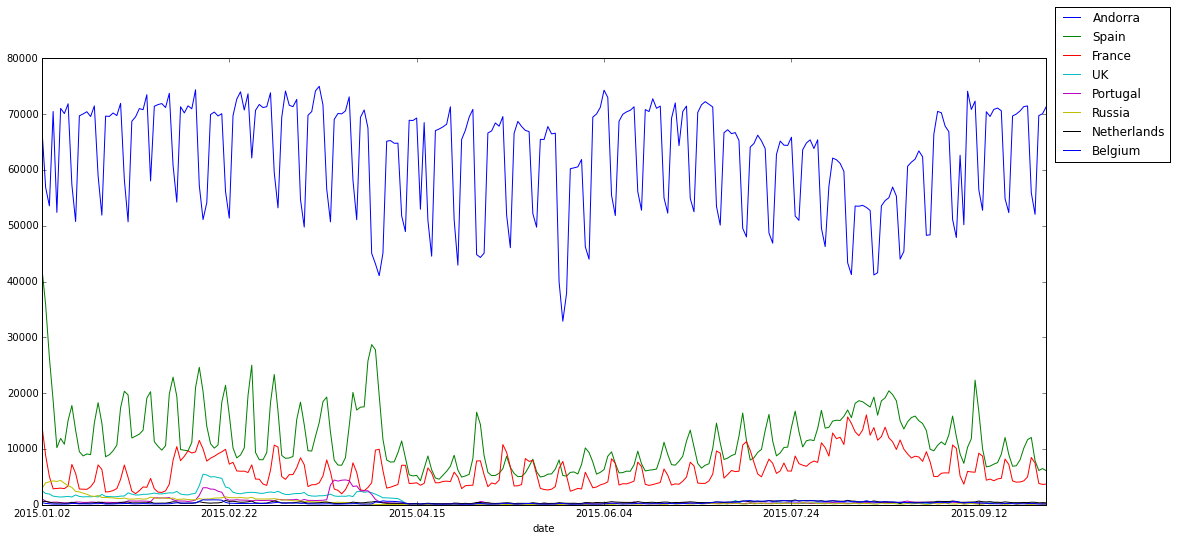

In [26]:

st_marys_df=pd.read_csv('timeseries.csv')
st_marys_df.index = st_marys_df.date
st_marys_df.plot(figsize=(18, 8))
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)

From Explonary analysis we could find French and Spainish dominate the population of tourists, and the peak seasons are in period of JAN01-JAN04(new Year Season), Feb(Ski season), the end of march,and summer peak.
So we subset data from the peak tourist season in timeseries.

In [17]:
st_marys_df.head()

,date,Andorra,Spain,France,UK,Portugal,Russia,Netherlands,Belgium
date,,,,,,,,,
2015.01.02,2015.01.02,67548,42455,14283,2536,1067,2885,627,385
2015.01.03,2015.01.03,56878,35841,8841,2027,673,3933,607,249
2015.01.04,2015.01.04,53573,26403,5061,1941,414,4123,462,196
2015.01.05,2015.01.05,70485,18674,2870,1556,463,4290,336,132
2015.01.06,2015.01.06,52407,10240,2927,1453,481,4185,313,122


Create subset data to Most popular tourists,(Spanish and French Tourists), and the time in peak time, such as Jan1-5

In [31]:
dfcand=pd.read_csv("201501_CDR.csv")

In [32]:
spaincdr=dfcand[(dfcand.ID_CDOPERADORORIGEN==21401) |(dfcand.ID_CDOPERADORORIGEN==21403)|(dfcand.ID_CDOPERADORORIGEN==21404)|(dfcand.ID_CDOPERADORORIGEN==21406)|(dfcand.ID_CDOPERADORORIGEN==21407)|(dfcand.ID_CDOPERADORORIGEN==21409) ]

In [33]:
import datetime
import requests
import time
import json
from datetime import time, date,datetime
spaincdr.ini= spaincdr.DT_CDDATAINICI.apply(pd.datetools.parse)

In [34]:
start_d=datetime(2015, 1,1)
end_d=datetime(2015, 1, 5)
start_d64=np.datetime64(start_d)
end_d64=np.datetime64(end_d)

In [35]:
frcdr=dfcand[(dfcand.ID_CDOPERADORORIGEN==20820) |(dfcand.ID_CDOPERADORORIGEN==20821)|(dfcand.ID_CDOPERADORORIGEN==20888)|(dfcand.ID_CDOPERADORORIGEN==20800)|(dfcand.ID_CDOPERADORORIGEN==20801)|(dfcand.ID_CDOPERADORORIGEN==20802)|(dfcand.ID_CDOPERADORORIGEN==20810)|(dfcand.ID_CDOPERADORORIGEN==20811)|(dfcand.ID_CDOPERADORORIGEN==20813) ]

In [36]:
frcdr.ini= frcdr.DT_CDDATAINICI.apply(pd.datetools.parse)

In [37]:
frcdr=frcdr[(frcdr.ini>start_d64) & (frcdr.ini <end_d64)]

In [39]:
spcdr=spaincdr[(spaincdr.ini>start_d64) & (spaincdr.ini <end_d64)]

In [40]:
frcdr.head()

,DS_CDNUMORIGEN,DT_CDDATAINICI,DT_CDDATAFI,NUM_DURADA,ID_CELLA_INI,ID_CELLA_FI,ID_CDOPERADORORIGEN
0,9aff9f9d53ebd77d2cc0edc6eddb761b0c1d5ae7166ea8...,2015.01.02 00:03:50,2015.01.02 00:03:50,0,2021,2021,20801
1,9aff9f9d53ebd77d2cc0edc6eddb761b0c1d5ae7166ea8...,2015.01.02 00:54:39,2015.01.02 00:54:39,0,2021,2021,20801
4,161e38db04f53740a00aaf1734d5b07a19381567261ebf...,2015.01.02 00:01:58,2015.01.02 00:01:58,0,19091,19091,20801
5,161e38db04f53740a00aaf1734d5b07a19381567261ebf...,2015.01.02 00:00:38,2015.01.02 00:00:38,0,19091,NaN,20801
11,a1497171f3fa9f67427840a9a2793445478f5dce51a717...,2015.01.02 01:24:00,2015.01.02 01:24:00,0,9162,9162,20801


In [41]:
spcdr.head()

,DS_CDNUMORIGEN,DT_CDDATAINICI,DT_CDDATAFI,NUM_DURADA,ID_CELLA_INI,ID_CELLA_FI,ID_CDOPERADORORIGEN
2,dae9a69bc8e7fb7c7e3b601290c578baf5c8963839bcba...,2015.01.02 01:49:43,2015.01.02 01:49:43,0,101,101,21407
3,957ce1627bfd2a625fb6645c11392e6b22a239604fd9a5...,2015.01.02 00:30:35,2015.01.02 00:30:42,7,3531,3531,21407
7,48fd6ec91031315f41edd9b7da56e23cac73f254c88818...,2015.01.02 01:31:46,2015.01.02 01:31:46,0,1030,1030,21407
13,b77556d8278e0fe0b8857c72fc4be6636c5a98f513841d...,2015.01.02 01:03:03,2015.01.02 01:03:03,0,130,130,21404
16,9e088ac7426ad53ca5ca48c8fa9db661de69799fc24182...,2015.01.02 00:45:05,2015.01.02 00:45:05,0,3620,3620,21407


Find the tourist individual travel pattern

In [42]:
spuserid=list(set(spcdr.DS_CDNUMORIGEN.values.tolist()))

In [43]:
fruserid=list(set(frcdr.DS_CDNUMORIGEN.values.tolist()))

In [44]:
spid_towers=[]
for i in xrange(len(spuserid)):
    spid_towers.append([])
len(spid_towers)   

71432

In [45]:
frid_towers=[]
for i in xrange(len(fruserid)):
    frid_towers.append([])
len(frid_towers)   

20949

In [48]:

for i in xrange(len(spuserid)):
    id_df=spcdr[(spcdr.DS_CDNUMORIGEN==spuserid[i])]

    id_index= id_df.index.values.tolist()
    
    for j,k in enumerate (id_index):
        k=int(k)
        tower_id=spcdr.loc[k]['ID_CELLA_INI']
        spid_towers[i].append(tower_id)
        

In [51]:
spset_towers=[]
for towers in spid_towers:

    new_towers=list(set([int(i) for i in towers]))
    spset_towers.append(new_towers)

In [52]:
spdata=[spuserid,spid_towers,spset_towers]
sp_df=pd.DataFrame(spdata).transpose()
sp_df.columns = ['user_id', 'tower_id',"set_tower_id"]

In [54]:
sp_df.to_csv('spuser_0102-04.csv')

In [55]:
sp_df

,user_id,tower_id,set_tower_id
0,0226f25f5b49a9c77ebf4eceed456bc3155a1d5ba50153...,"[1760, 2030, 2030, 2030, 1760, 2030, 2030, 2030]","[1760, 2030]"
1,26dd7c1d853b228cae5d21cf1a4d7143baaabad8299165...,"[9011, 9031, 46, 9011, 9430, 1001, 9041, 56, 5...","[9031, 1001, 45, 46, 9040, 9041, 9042, 9011, 9..."
2,0d5357e20f6e097b5eeedaf7b67c89a6aa384bee22fda7...,"[460, 505, 56, 460, 460, 505, 56, 460]","[56, 505, 460]"
3,6fd835a1ed5fb2c9c4a923dc45fcf626fef570094cc934...,"[3630, 3630, 3630, 3230, 3230, 3230, 3521, 323...","[3520, 3521, 3230, 3630]"
4,dd2644bdcc497fcab9242c676a17e4278a7a4ce5f15cd4...,"[70, 70, 70, 70]",[70]
5,4f83008791e17dc9ebc0fc631b389babc7ebc7b3a6dd88...,"[96, 96]",[96]
6,365e95e607cbf10603b83cf07429816d2b1fe1f61ec094...,"[480, 3530, 9080, 9080, 3040, 3040, 3040, 9080...","[480, 3040, 3530, 80, 19091, 9080]"
7,14c104cbc2eaab053263001abd1d4adfdf5dbc50464fd0...,"[2041, 2060, 2041, 2060]","[2041, 2060]"
8,a28416e80b83629f4520a1351bc4b2c1eef546f84d5335...,"[1091, 1091, 1091, 481, 3620, 1091, 221, 221, ...","[200, 481, 1091, 3620, 221]"
9,467a22cfd813e8d5ea33bd3428b28936bd7830ca6bd0f0...,"[342, 342, 1171, 342, 9430, 1171, 1171, 1171, ...","[1171, 436, 9430, 342]"


In [56]:
for i in xrange(len(fruserid)):
    id_df=frcdr[(frcdr.DS_CDNUMORIGEN==fruserid[i])]

    id_index= id_df.index.values.tolist()
    
    for j,k in enumerate (id_index):
        k=int(k)
        tower_id=frcdr.loc[k]['ID_CELLA_INI']
        frid_towers[i].append(tower_id)

In [58]:
frset_towers=[]
for towers in frid_towers:

    new_towers=list(set([int(i) for i in towers]))
    frset_towers.append(new_towers)
    


In [59]:
frdata=[fruserid,frid_towers,frset_towers]
fr_df=pd.DataFrame(frdata).transpose()

fr_df.columns = ['user_id', 'tower_id',"set_tower_id"]

In [61]:

fr_df.to_csv('fruser_0102-04.csv')

Create other features for the user, such as the how many days they stay in each cities, and how many days they are in Andorra.

In [62]:
import csv

FILES = ["2015_0101-08.csv"]

with open("towers_Container.csv", 'rU') as cities_file:
  cities_set = set()
  cities_reader = csv.DictReader(cities_file)
  cities_dict = {}
  for city_row in cities_reader:
    cities_dict[city_row["place_id"]] = city_row["Cluster"]
    cities_set.add(city_row["Cluster"])

with open("countrycode.csv", 'rU') as country_file:
  country_reader = csv.DictReader(country_file)
  next(country_reader, None)
  country_dict = {}
  for country_row in country_reader:
    if country_row["country_name"] == "Spain":
      country_dict[country_row["country"]] = "Spain"

for f in FILES:
  with open("{}_spain_cdr_user_cities.csv".format(f[:-4]), "w") as cities_file:
    header = ['user_id']
    header += sorted(cities_set)
    header.append("Other")
    header.append("Days")

    writer = csv.DictWriter(cities_file, fieldnames = header)
    writer.writeheader()

    results_dict = {}
    with open(f, "r") as cdr_file:
      cdr_reader = csv.DictReader(cdr_file)
      count = 0
      for cdr_row in cdr_reader:
        count += 1
        if count % 500000 == 0:
          print "Row " + str(count)
        if country_dict.get(cdr_row["ID_CDOPERADORORIGEN"]) is None:
          continue
        user_id = cdr_row["DS_CDNUMORIGEN"]
        date = cdr_row["DT_CDDATAINICI"].split()[0]
        if cities_dict.get(cdr_row["ID_CELLA_INI"]) is None:
          incity = "Other"
        else:
          incity = cities_dict[cdr_row["ID_CELLA_INI"]]
        if cities_dict.get(cdr_row["ID_CELLA_FI"]) is None:
          outcity = "Other"
        else:
          outcity = cities_dict[cdr_row["ID_CELLA_FI"]]
        if results_dict.get(user_id) is None: #user isn't in result_dict
          day_dict = {}
          cities_per_day = set()
          cities_per_day.add(incity)
          cities_per_day.add(outcity)
          day_dict[date] = cities_per_day

          results_dict[user_id] = day_dict
        else:
          user_dict = results_dict[user_id]
          if user_dict.get(date) is None:  #user in result_dict but date not in user_dict yet
            user_dict[date] = set([incity, outcity])
          else:                                     #user in result_dict and date in user_dict already
            user_dict[date].add(incity)
            user_dict[date].add(outcity)
      print "Writing Now"

    write_count = 0
    for user, user_result_dict in results_dict.iteritems():
      write_count += 1
      dict_to_write = {"user_id": user}
      for day, all_cities in user_result_dict.iteritems():
        for city1 in all_cities:
          if dict_to_write.get(city1) is None:
            dict_to_write[city1] = 1
          else:
            dict_to_write[city1] += 1
      for city2 in header[1:-1]:
        if dict_to_write.get(city2) is None:
          dict_to_write[city2] = 0
      dict_to_write["Days"] = len(user_result_dict.keys())
      if write_count % 50000 == 0:
        print "Wrote " + str(write_count) + " users"
      writer.writerow(dict_to_write)
  print "Done with file " + f

Row 500000
Row 1000000
Row 1500000
Row 2000000
Row 2500000
Row 3000000
Row 3500000
Row 4000000
Writing Now
Done with file 2015_0101-08.csv


In [63]:
import csv

FILES = ["2015_0101-08.csv"]

with open("towers_Container.csv", 'rU') as cities_file:
  cities_set = set()
  cities_reader = csv.DictReader(cities_file)
  cities_dict = {}
  for city_row in cities_reader:
    cities_dict[city_row["place_id"]] = city_row["Cluster"]
    cities_set.add(city_row["Cluster"])

with open("countrycode.csv", 'rU') as country_file:
  country_reader = csv.DictReader(country_file)
  next(country_reader, None)
  country_dict = {}
  for country_row in country_reader:
    if country_row["country_name"] == "France":
      country_dict[country_row["country"]] = "France"

for f in FILES:
  with open("{}_france_cdr_user_cities.csv".format(f[:-4]), "w") as cities_file:
    header = ['user_id']
    header += sorted(cities_set)
    header.append("Other")
    header.append("Days")

    writer = csv.DictWriter(cities_file, fieldnames = header)
    writer.writeheader()

    results_dict = {}
    with open(f, "r") as cdr_file:
      cdr_reader = csv.DictReader(cdr_file)
      count = 0
      for cdr_row in cdr_reader:
        count += 1
        if count % 500000 == 0:
          print "Row " + str(count)
        if country_dict.get(cdr_row["ID_CDOPERADORORIGEN"]) is None:
          continue
        user_id = cdr_row["DS_CDNUMORIGEN"]
        date = cdr_row["DT_CDDATAINICI"].split()[0]
        if cities_dict.get(cdr_row["ID_CELLA_INI"]) is None:
          incity = "Other"
        else:
          incity = cities_dict[cdr_row["ID_CELLA_INI"]]
        if cities_dict.get(cdr_row["ID_CELLA_FI"]) is None:
          outcity = "Other"
        else:
          outcity = cities_dict[cdr_row["ID_CELLA_FI"]]
        if results_dict.get(user_id) is None: #user isn't in result_dict
          day_dict = {}
          cities_per_day = set()
          cities_per_day.add(incity)
          cities_per_day.add(outcity)
          day_dict[date] = cities_per_day

          results_dict[user_id] = day_dict
        else:
          user_dict = results_dict[user_id]
          if user_dict.get(date) is None:  #user in result_dict but date not in user_dict yet
            user_dict[date] = set([incity, outcity])
          else:                                     #user in result_dict and date in user_dict already
            user_dict[date].add(incity)
            user_dict[date].add(outcity)
      print "Writing Now"

    write_count = 0
    for user, user_result_dict in results_dict.iteritems():
      write_count += 1
      dict_to_write = {"user_id": user}
      for day, all_cities in user_result_dict.iteritems():
        for city1 in all_cities:
          if dict_to_write.get(city1) is None:
            dict_to_write[city1] = 1
          else:
            dict_to_write[city1] += 1
      for city2 in header[1:-1]:
        if dict_to_write.get(city2) is None:
          dict_to_write[city2] = 0
      dict_to_write["Days"] = len(user_result_dict.keys())
      if write_count % 50000 == 0:
        print "Wrote " + str(write_count) + " users"
      writer.writerow(dict_to_write)
  print "Done with file " + f


Row 500000
Row 1000000
Row 1500000
Row 2000000
Row 2500000
Row 3000000
Row 3500000
Row 4000000
Writing Now
Done with file 2015_0101-08.csv


In festicval periods, French and Spainish Tourists 

In [64]:
French0108_df=pd.read_csv("0108france_cdr_user_cities.csv")
French0108_df.head()

,user_id,CL0 - StJulia,CL1 - Centre,CL2 - Massana,CL3 - Arans,CL4 - Encamp,CL5 - Soldeu,CL6 - PasDeLaCasa,Global,Other,Days
0,2786dd6755d92c4a4721596f7236f3a288edc9e35e7236...,0,0,0,0,0,0,1,0,0,1
1,2934f48d0c80a3109e4b387a630b3de6533dc016dcc7f2...,0,2,0,0,0,0,0,0,1,2
2,60bd865a015eec6ecc298edc6dc9519e64ebefd9020115...,0,0,0,0,0,0,2,0,0,2
3,a15cfb1b16cdb6a0ef0560440a4cf8cb363542b18fe011...,0,1,0,0,0,0,0,0,0,1
4,d3c26903b5d63fc8520151eddfc5f4a1214b5ffea97ed1...,0,1,0,0,1,0,1,0,0,1


In [65]:
Spain0108_df=pd.read_csv("0108spain_cdr_user_cities.csv")
Spain0108_df.head()

,user_id,CL0 - StJulia,CL1 - Centre,CL2 - Massana,CL3 - Arans,CL4 - Encamp,CL5 - Soldeu,CL6 - PasDeLaCasa,Global,Other,Days
0,0226f25f5b49a9c77ebf4eceed456bc3155a1d5ba50153...,1,0,0,0,0,0,0,0,0,1
1,0d5357e20f6e097b5eeedaf7b67c89a6aa384bee22fda7...,0,1,0,0,0,0,0,0,0,1
2,6fd835a1ed5fb2c9c4a923dc45fcf626fef570094cc934...,0,0,0,0,0,1,1,0,0,2
3,dd2644bdcc497fcab9242c676a17e4278a7a4ce5f15cd4...,0,0,0,0,1,0,0,0,0,1
4,4f83008791e17dc9ebc0fc631b389babc7ebc7b3a6dd88...,0,1,0,0,0,0,0,0,0,1


In whole month of January, French and Spainish Tourists

In [66]:
French01_df=pd.read_csv("201501_france_cdr_user_cities.csv")
French01_df.head()

,user_id,CL0 - StJulia,CL1 - Centre,CL2 - Massana,CL3 - Arans,CL4 - Encamp,CL5 - Soldeu,CL6 - PasDeLaCasa,Global,Other,Days
0,00a643ef6e416ea77c6b29c413b17988eadb93e07cc01a...,1,1,0,0,1,0,0,0,1,1
1,7b7be780d3796da251ea3d647dfae1c4aaf868ec1e8a52...,0,0,0,0,0,0,1,0,0,1
2,3cad1c56a009870e79dee4885b4a09a26bb91361403f49...,0,0,0,0,0,0,0,0,1,1
3,74b709c25a0756a0d617ce967b13323b285bd4ee9a2e1c...,0,0,0,0,0,0,0,0,1,1
4,54ff5c8e35f818c281be12adffffb4350280c043b690a0...,0,0,0,0,0,0,1,0,0,1


In [67]:
Spain01_df=pd.read_csv("201501_spain_cdr_user_cities.csv")
Spain01_df.head()

,user_id,CL0 - StJulia,CL1 - Centre,CL2 - Massana,CL3 - Arans,CL4 - Encamp,CL5 - Soldeu,CL6 - PasDeLaCasa,Global,Other,Days
0,3c0acda2ce48e05127e8942a334d349f3bf489afe01f78...,0,1,0,0,1,0,0,0,0,1
1,26dd7c1d853b228cae5d21cf1a4d7143baaabad8299165...,2,2,0,0,0,0,0,0,0,2
2,62d8291d684faf05dc810119a5e13efb3b2b418e78e5d8...,1,0,0,0,0,0,0,0,0,1
3,6eee79335427efbcb9706bf4dd694d5ef2d263db08a366...,1,0,0,0,0,0,0,0,0,1
4,534cc857bd338f88064a523a7dd5547f4071243e833c02...,1,0,0,0,0,0,0,0,0,1


In [70]:
Fr_grouped=French01_df.groupby("Days")
Sp_grouped=Spain01_df.groupby("Days")

In [76]:
Fr_01_dict=Fr_grouped.groups
Sp_01_dict=Sp_grouped.groups

In [109]:
frdays={}
frpop=[]
sppop=[]
frday=[]
spday=[]
for key, value in Fr_01_dict.iteritems():
    population=len(value)
    frpop.append(population)
    frdays[key]=population
    frday.append(key)
spdays={}
for key, value in Sp_01_dict.iteritems():
    population=len(value)
    sppop.append(population)
    spdays[key]=population
    spday.append(key)

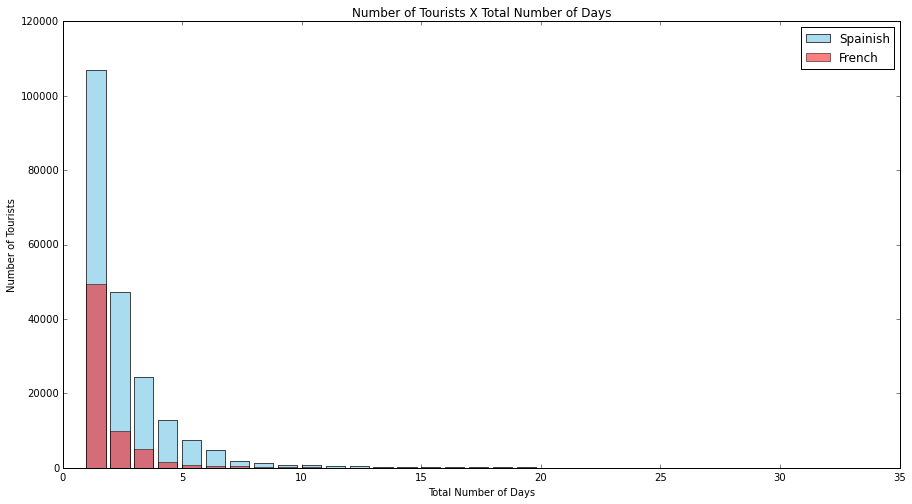

In [107]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

rects1 = ax.bar(spday, sppop,color='skyblue',alpha=0.7)
rects2 = ax.bar(frday, frpop,color='red',alpha=0.5)
ax.legend( (rects1[0], rects2[0]), ('Spainish', 'French') )
ax.set_ylabel('Number of Tourists')
ax.set_xlabel('Total Number of Days')
ax.set_title('Number of Tourists X Total Number of Days')
plt.show()

In [134]:
fr01_cities=frday_pairs[1]
sp01_cities=spday_pairs[1]
city_number=[1,2,3,4,5,6,7]
city_name= ["",'CL0 - StJulia','CL1 - Centre','CL2 - Massana','CL3 - Arans','CL4 - Encamp','CL5 - Soldeu','CL6 - PasDeLaCasa']

In [125]:
frday_pairs={}
for name, group in Fr_grouped:
    
    c0=group['CL0 - StJulia'].sum()
    c1=group['CL1 - Centre'].sum()
    c2=group['CL2 - Massana'].sum()
    c3=group['CL3 - Arans'].sum()
    c4=group['CL4 - Encamp'].sum()
    c5=group['CL5 - Soldeu'].sum()
    c6=group['CL6 - PasDeLaCasa'].sum()
    cities_num=[c0,c1,c2,c3,c4,c5,c6]
    frday_pairs[name]=cities_num
    
spday_pairs={}
for name, group in Sp_grouped:
    
    c0=group['CL0 - StJulia'].sum()
    c1=group['CL1 - Centre'].sum()
    c2=group['CL2 - Massana'].sum()
    c3=group['CL3 - Arans'].sum()
    c4=group['CL4 - Encamp'].sum()
    c5=group['CL5 - Soldeu'].sum()
    c6=group['CL6 - PasDeLaCasa'].sum()
    cities_num=[c0,c1,c2,c3,c4,c5,c6]
    spday_pairs[name]=cities_num   

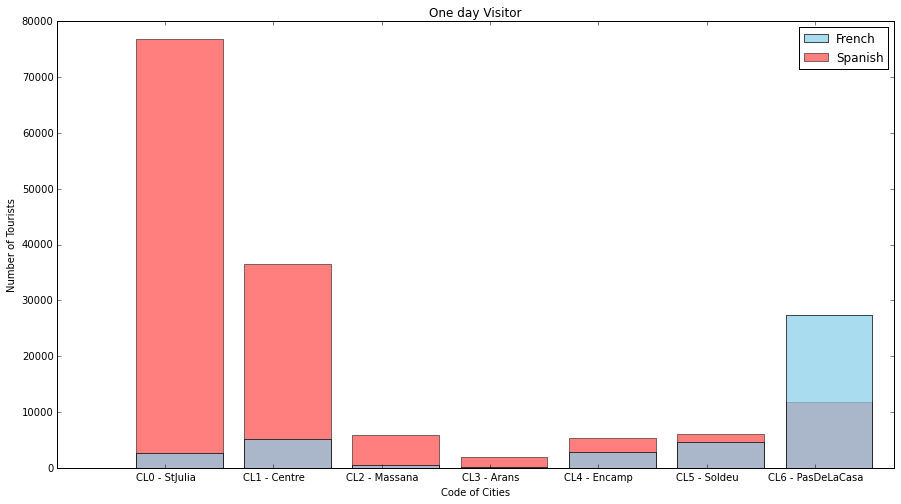

In [143]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ind = np.arange(8)  
width = 0.27 

rects2 = ax.bar(city_number,sp01_cities,color='red',alpha=0.5)
rects1 = ax.bar(city_number,fr01_cities,color='skyblue',alpha=0.7)
ax.legend( (rects1[0], rects2[0]), ('French', 'Spanish') )
ax.set_xticks(ind+width)
ax.set_xticklabels( city_name )
ax.set_ylabel('Number of Tourists')
ax.set_xlabel('Code of Cities')
ax.set_title('One day Visitor')
plt.show()

In [130]:
fr02_cities=frday_pairs[2]
sp02_cities=spday_pairs[2]
city_number=[1,2,3,4,5,6,7]
city_name= ['CL0 - StJulia','CL1 - Centre','CL2 - Massana','CL3 - Arans','CL4 - Encamp','CL5 - Soldeu','CL6 - PasDeLaCasa']

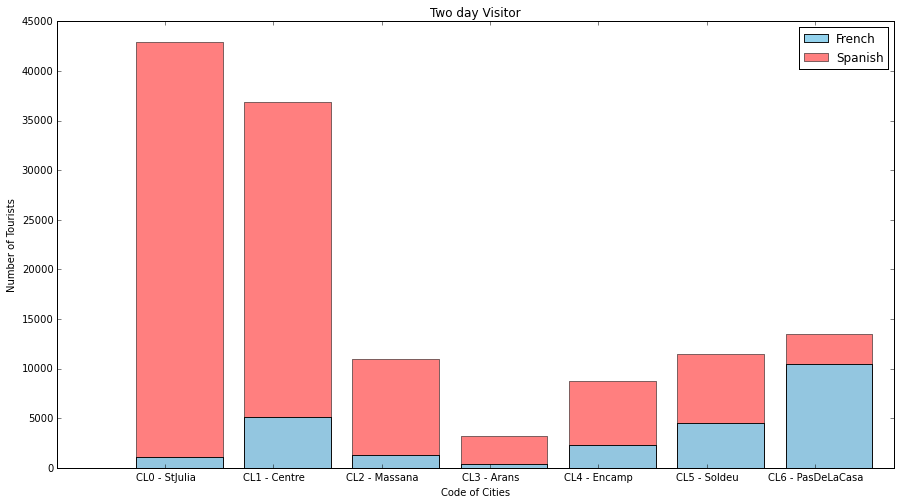

In [139]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ind = np.arange(8)  
width = 0.27 

rects2 = ax.bar(city_number,sp02_cities,color='red',alpha=0.5)
rects1 = ax.bar(city_number,fr02_cities,color='skyblue',alpha=0.9)
ax.legend( (rects1[0], rects2[0]), ('French', 'Spanish') )
ax.set_xticks(ind+width)
ax.set_xticklabels( city_name )
ax.set_ylabel('Number of Tourists')
ax.set_xlabel('Code of Cities')
ax.set_title('Two day Visitor')
plt.show()

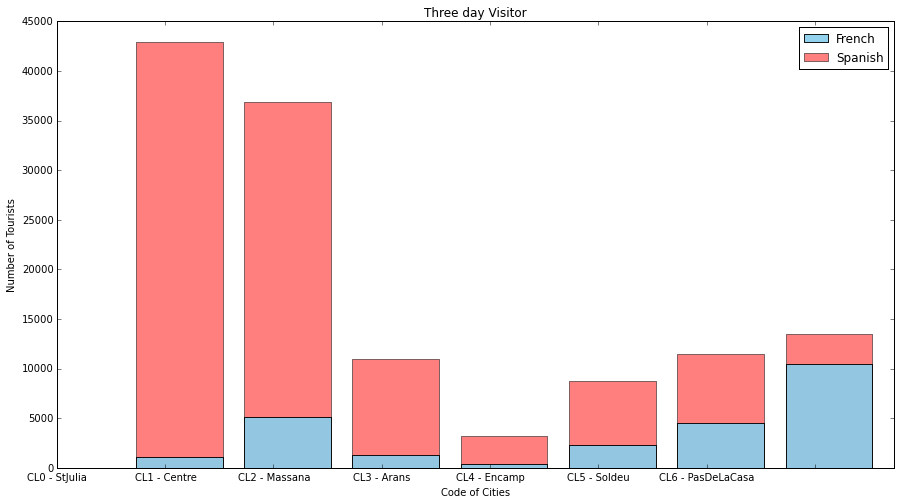

In [145]:
fr03_cities=frday_pairs[3]
sp03_cities=spday_pairs[3]
city_number=[1,2,3,4,5,6,7]
city_name= ['CL0 - StJulia','CL1 - Centre','CL2 - Massana','CL3 - Arans','CL4 - Encamp','CL5 - Soldeu','CL6 - PasDeLaCasa']
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ind = np.arange(8)  
width = 0.27 

rects2 = ax.bar(city_number,sp02_cities,color='red',alpha=0.5)
rects1 = ax.bar(city_number,fr02_cities,color='skyblue',alpha=0.9)
ax.legend( (rects1[0], rects2[0]), ('French', 'Spanish') )
ax.set_xticks(ind+width)
ax.set_xticklabels( city_name )
ax.set_ylabel('Number of Tourists')
ax.set_xlabel('Code of Cities')
ax.set_title('Three day Visitor')
plt.show()

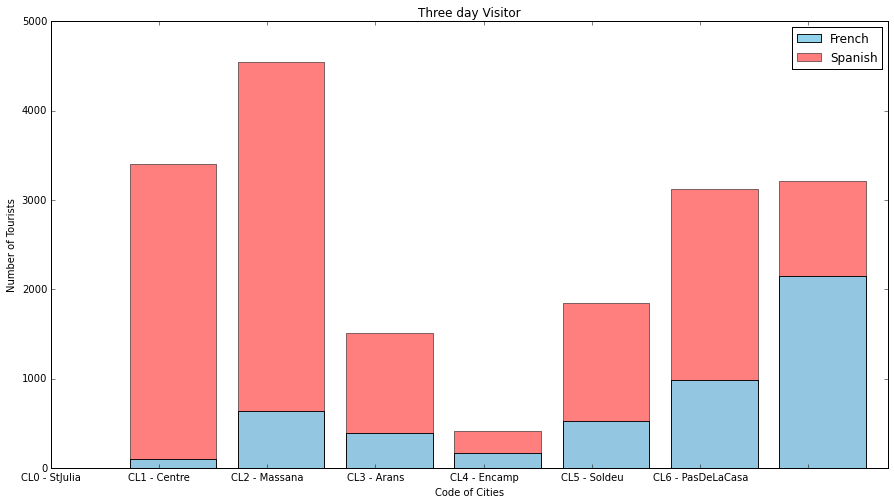

In [146]:
fr07_cities=frday_pairs[7]
sp07_cities=spday_pairs[7]
city_number=[1,2,3,4,5,6,7]
city_name= ['CL0 - StJulia','CL1 - Centre','CL2 - Massana','CL3 - Arans','CL4 - Encamp','CL5 - Soldeu','CL6 - PasDeLaCasa']
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ind = np.arange(8)  
width = 0.27 

rects2 = ax.bar(city_number,sp07_cities,color='red',alpha=0.5)
rects1 = ax.bar(city_number,fr07_cities,color='skyblue',alpha=0.9)
ax.legend( (rects1[0], rects2[0]), ('French', 'Spanish') )
ax.set_xticks(ind+width)
ax.set_xticklabels( city_name )
ax.set_ylabel('Number of Tourists')
ax.set_xlabel('Code of Cities')
ax.set_title('Three day Visitor')
plt.show()

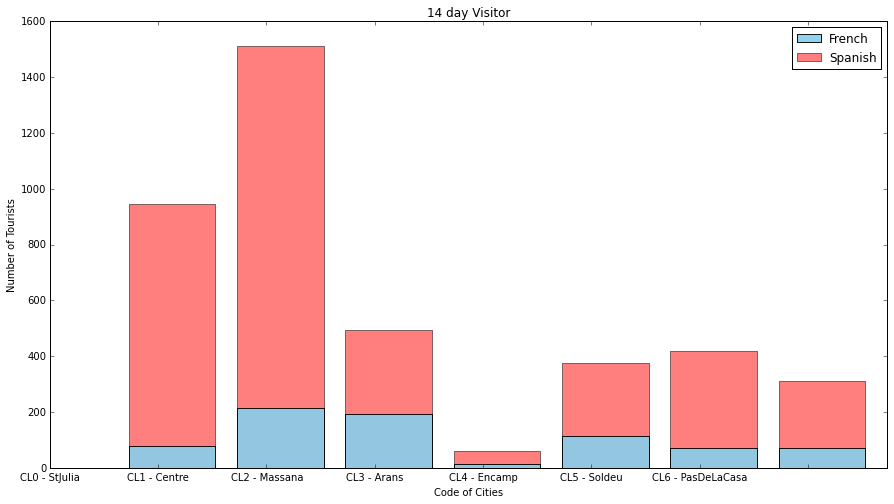

In [147]:
fr14_cities=frday_pairs[14]
sp14_cities=spday_pairs[14]
city_number=[1,2,3,4,5,6,7]
city_name= ['CL0 - StJulia','CL1 - Centre','CL2 - Massana','CL3 - Arans','CL4 - Encamp','CL5 - Soldeu','CL6 - PasDeLaCasa']
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ind = np.arange(8)  
width = 0.27 

rects2 = ax.bar(city_number,sp14_cities,color='red',alpha=0.5)
rects1 = ax.bar(city_number,fr14_cities,color='skyblue',alpha=0.9)
ax.legend( (rects1[0], rects2[0]), ('French', 'Spanish') )
ax.set_xticks(ind+width)
ax.set_xticklabels( city_name )
ax.set_ylabel('Number of Tourists')
ax.set_xlabel('Code of Cities')
ax.set_title('14 day Visitor')
plt.show()

# Use Association Rule to see the tourist most likely to go in next step, and relationshop between different cities for each city

In [14]:
from __future__ import division
from pymining import itemmining, assocrules, perftesting
from sets import Set
import csv
import json
# change dates as y.m.d format for events

/Users/nai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: the sets module is deprecated
  app.launch_new_instance()


In [148]:
from __future__ import division
#from pybrain.tools.shortcuts import buildNetwork
#from pybrain.supervised.trainers import BackpropTrainer
#from pybrain.datasets import SupervisedDataSet,UnsupervisedDataSet
#from pybrain.structure import LinearLayer
from pymining import itemmining, assocrules, perftesting
from sets import Set
import csv
import json
import datetime
import time
#import struct
from sklearn import ensemble
months = {"Jan":'201501.csv'}
# Single result for a set period of time
months={1:'201501_CDR.csv'}
FranceCC={'20820','20821',
'20888',
'20800',
'20801',
'20802',
'20810',
'20811',
'20813'}
SpainCC={'21401',
'21406',
'21409',
'21403',
'21407',
'21404'}
AndorraCC={'21303'}
others={'21303','21401',
'21406',
'21409',
'21403',
'21407',
'21404','20820','20821',
'20888',
'20800',
'20801',
'20802',
'20810',
'20811',
'20813'}
towers={}
#annotated towers by area
t = open('towersArea.csv','rU')
tdata = csv.reader(t)
areas=[]
areaMap={}

for row in tdata:
     if row[5] !='CELL Latitude WGS84'  and len(row[5])>0 and len(row[6])>0:
          towers[row[4]]={"area":row[7],"lat":float(row[5]),"lng":float(row[6])}
          if row[7] not in areas:
               areas.append(row[7])
               areaMap[len(areas)-1]={"lat":float(row[5]),"lng":float(row[6])}
users={}
for month in months:
     o = open(months[month],'rU')
     mydata = csv.reader(o)
     count =0
     row1=[]
     towerIndex=0
     countryIndex=1
     for row in mydata:
          count+=1
          if count==1:
               row1=row
               print row
               towerIndex = row1.index('inicell') if 'inicell' in row1 else row1.index('ID_CELLA_INI')
               countryIndex = row1.index('country') if 'country' in row1 else row1.index('ID_CDOPERADORORIGEN')
               pass
          else:
               if count>10000000:
                    break
               try:
                    if not row[towerIndex] in towers or row[countryIndex] in AndorraCC or not row[countryIndex]:
                         pass
                    else:
                         tower=towers[row[towerIndex]]["area"]
                         t = datetime.datetime.strptime(row[1], '%Y.%m.%d %H:%M:%S')
                         t = 100*t.month +t.day
                         if row[0] in users:
                              if not users[row[0]]["locations"][len(users[row[0]]["locations"])-1] ==areas.index(tower):
                                 users[row[0]]["locations"].append(areas.index(tower))
                                 users[row[0]]["lats"].append(float(towers[row[towerIndex]]["lat"]))
                                 users[row[0]]["longs"].append(float(towers[row[towerIndex]]["lng"]))
                                 users[row[0]]["time"].append(t)
                         else:
                                 users[row[0]] = {"month":month,"locations":[areas.index(tower)],
                                                  "country":float(row[countryIndex]),"time":[t],
                                                  "lats":[float(towers[row[towerIndex]]["lat"])],
                                                  "longs":[float(towers[row[towerIndex]]["lng"])]
                                                  }
               except IndexError:
                     print row
          if count%1000000==0:
               print count
     print "done"
X=[]
Y=[]
Xtest=[]
Ytest=[]
userIndex= users.keys()
count =0

offset=4
print len(users)
trainingUserCount= 100000
for u in users:
    user = users[u]
    count+=1
    if count%10000==0:
         print count
    if len(user["time"])>offset+2:
         uid= userIndex.index(u)
         if(count<=trainingUserCount):
              for i in range (offset,len(user["locations"])-2):
                  X.append([user["lats"][i],user["longs"][i]])
                  Y.append(user["locations"][i+1])
         else:
              pass

print "loaded"

clf = ensemble.RandomForestClassifier(n_estimators=10)
clf.fit(X, Y)
suc=0;


#Predict the next location based on a single previous location
results={"map":[]}
for t in towers:
    loc=[towers[t]["lat"],towers[t]["lng"]]
    tow=clf.predict(loc)
    toLoc=areaMap[tow[0]]
    results["map"].append({"from":loc, "to":toLoc})
    
#Change 'predict.json' to whatever file you want. This is the output. Use to visualize via nextLocation folder's map.html 
with open('predict.JSON', 'w') as outfile:
    json.dump(results, outfile)




    

['DS_CDNUMORIGEN', 'DT_CDDATAINICI', 'DT_CDDATAFI', 'NUM_DURADA', 'ID_CELLA_INI', 'ID_CELLA_FI', 'ID_CDOPERADORORIGEN']
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
done
232075
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
loaded


/Users/nai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning:

the sets module is deprecated



# Use RandomForest to predict the NextStation the Tourist is mostly like to go

In [ ]:
from __future__ import division
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet,UnsupervisedDataSet
from pybrain.structure import LinearLayer
from pymining import itemmining, assocrules, perftesting
from sets import Set
import csv
import json
import datetime
import time
import struct
from sklearn import ensemble
months = {"Jan":'201501.csv'}
# Single result for a set period of time
months={1:'201501_CDR.csv'}
FranceCC={'20820','20821',
'20888',
'20800',
'20801',
'20802',
'20810',
'20811',
'20813'}
SpainCC={'21401',
'21406',
'21409',
'21403',
'21407',
'21404'}
AndorraCC={'21303'}
others={'21303','21401',
'21406',
'21409',
'21403',
'21407',
'21404','20820','20821',
'20888',
'20800',
'20801',
'20802',
'20810',
'20811',
'20813'}
towers={}
#annotated towers by area
t = open('towersArea.csv','rU')
tdata = csv.reader(t)
areas=[]
areaMap={}

for row in tdata:
     if row[5] !='CELL Latitude WGS84'  and len(row[5])>0 and len(row[6])>0:
          towers[row[4]]={"area":row[7],"lat":float(row[5]),"lng":float(row[6])}
          if row[7] not in areas:
               areas.append(row[7])
               areaMap[len(areas)-1]={"lat":float(row[5]),"lng":float(row[6])}
users={}
for month in months:
     o = open(months[month],'rU')
     mydata = csv.reader(o)
     count =0
     row1=[]
     towerIndex=0
     countryIndex=1
     for row in mydata:
          count+=1
          if count==1:
               row1=row
               print row
               towerIndex = row1.index('inicell') if 'inicell' in row1 else row1.index('ID_CELLA_INI')
               countryIndex = row1.index('country') if 'country' in row1 else row1.index('ID_CDOPERADORORIGEN')
               pass
          else:
               if count>10000000:
                    break
               try:
                    if not row[towerIndex] in towers or row[countryIndex] in AndorraCC or not row[countryIndex]:
                         pass
                    else:
                         tower=towers[row[towerIndex]]["area"]
                         t = datetime.datetime.strptime(row[1], '%Y.%m.%d %H:%M:%S')
                         t = 100*t.month +t.day
                         if row[0] in users:
                              if not users[row[0]]["locations"][len(users[row[0]]["locations"])-1] ==areas.index(tower):
                                 users[row[0]]["locations"].append(areas.index(tower))
                                 users[row[0]]["lats"].append(float(towers[row[towerIndex]]["lat"]))
                                 users[row[0]]["longs"].append(float(towers[row[towerIndex]]["lng"]))
                                 users[row[0]]["time"].append(t)
                         else:
                                 users[row[0]] = {"month":month,"locations":[areas.index(tower)],
                                                  "country":float(row[countryIndex]),"time":[t],
                                                  "lats":[float(towers[row[towerIndex]]["lat"])],
                                                  "longs":[float(towers[row[towerIndex]]["lng"])]
                                                  }
               except IndexError:
                     print row
          if count%1000000==0:
               print count
     print "done"
X=[]
Y=[]
Xtest=[]
Ytest=[]
userIndex= users.keys()
count =0

offset=4
print len(users)
trainingUserCount= 100000
for u in users:
    user = users[u]
    count+=1
    if count%10000==0:
         print count
    if len(user["time"])>offset+2:
         uid= userIndex.index(u)
         if(count<=trainingUserCount):
              for i in range (offset,len(user["locations"])-2):
                  X.append([user["lats"][i],user["longs"][i]])
                  Y.append(user["locations"][i+1])
         else:
              pass

print "loaded"

clf = ensemble.RandomForestClassifier(n_estimators=10)
clf.fit(X, Y)
suc=0;


#Predict the next location based on a single previous location
results={"map":[]}
for t in towers:
    loc=[towers[t]["lat"],towers[t]["lng"]]
    tow=clf.predict(loc)
    toLoc=areaMap[tow[0]]
    results["map"].append({"from":loc, "to":toLoc})
    
#Change 'predict.json' to whatever file you want. This is the output. Use to visualize via nextLocation folder's map.html 
with open('predict.JSON', 'w') as outfile:
    json.dump(results, outfile)




    

